In [1]:
import numpy as np
import math
import collections
import random
from scipy.optimize import linprog
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

init_notebook_mode(connected=True)

In [2]:
def hist(samp_list, min_s, max_s):
    h = [0] * (max_s - min_s + 1)
    for i in samp_list:
        h[i-min_s] += 1
    return h

def makeFingerPrint(samp_list):
    max_s = max(samp_list)
    min_s = min(samp_list)
    h1 = hist(samp_list, min_s, max_s)
    f = hist(h1, 0, max(h1))
    f = f[1:]
    return f

In [3]:
#FOR UNSEEN
def poisspdf(x, l):
    v1 = math.pow(l, x)
    v2 = math.factorial(x)
    v3 = math.pow(math.e, -l)
    final = (v1 / v2) * v3
    return final

def getSampleSize(f):
    k = 0
    for i,entry in enumerate(f):
        k = k + entry * (i+1)
    return k

#check
def getFirstNonZeroIndex(f):
    for i,entry in enumerate(f):
        if(entry != 0):
            return i+1

#check
def getLastNonZeroIndex(f):
    for i, entry in reversed(list(enumerate(f))):
        if(entry != 0):
            return i+1
        return -1

def getProbabilityMass(x, histx):
    pmass = 0
    for i, x_entry in enumerate(x):
        pmass = pmass + x_entry * histx[i]
    return pmass

def init_XLP(xLPmax, xLPmin, gridFactor):
    max_pow = math.ceil(math.log(xLPmax/xLPmin) / math.log(gridFactor))
    xLP = []
    for i in range(0, max_pow+1):
        xLP.append(xLPmin * math.pow(gridFactor, i))
    return xLP

def init_objf(szLPx, szLPf, fLP):
    objf = [0] * (szLPx + 2*szLPf)
    j = 0
    for i in range(szLPx, len(objf), 2):
        objf[i] = 1 / math.sqrt(fLP[j] + 1)
        j = j + 1
    j = 0
    for i in range(szLPx+1, len(objf), 2):
        objf[i] = 1 / math.sqrt(fLP[j] + 1)
        j = j + 1
    return objf

def init_A_b(szLPf, szLPx, xLP, fLP, k):
    #A = [[0] * (szLPx + 2 * szLPf)] * 2*szLPf
    A = []
    for i in range(2*szLPf):
        tmp = []
        for j in range(szLPx + 2 * szLPf):
            tmp.append(0)
        A.append(tmp)
    
    b = [0] * (2*szLPf)
    for i in range (0, szLPf):
        for j in range(0, szLPx):
            A[2 * i][j] = poisspdf(i+1, k * xLP[j])
        for k in range(0, szLPx):
            A[2*i+1][k] = -1 * A[2*i][k]
        A[2 * i][szLPx + 2 * i] = -1
        A[(2 * i)  + 1][szLPx + (2 * i)  + 1] = -1
        b[2 * i] = fLP[i]
        b[(2 * i)  + 1] = -fLP[i]
    
    return A,b

def rescale_cond(A, Aeq, xLP, szLPx):
    for i in range(0, szLPx):
        for j in range(0, len(A)):
            A[j][i] = A[j][i]/xLP[i]
        Aeq[i] = Aeq[i]/xLP[i]
    return A, Aeq

In [4]:
def unseen(f, gridFactor = 1.05):
    k = getSampleSize(f)
    
    alpha = 0.5
    
    xLPmin = 1 / (k * max(10,k))
    
    min_i = getFirstNonZeroIndex(f) #Returning index + 1
    
    if min_i > 1:
        xLPmin = min_i/k
    
    maxLPIters = 1000
    x = [0]
    histx = [0]
    
    fLP = [0] * len(f)
    for i in range(0, len(f)):
        i_m = i+1
        if(f[i] > 0):
            wind = [max(1, i_m - math.ceil(math.sqrt(i_m))), 
                    min(i_m + math.ceil(math.sqrt(i_m)), len(f))]
            
            low_ind = wind[0] - 1
            high_ind = wind[1]
            sum_f = sum(f[low_ind : high_ind])
            if( sum_f < math.sqrt(i_m)):
                x.append(i_m/k)
                histx.append(f[i])
                fLP[i] = 0
            else:
                fLP[i] = f[i]
    
    #If no LP portion, retun the empirical histogram
    fmax = getLastNonZeroIndex(f)
    if(fmax == -1):
        x.pop(0)
        histx.pop(0)
        return [x, histx]
    
    #Setting up first LP
    LPmass = 1 - getProbabilityMass(x, histx)
    
    z_flp = [0] * math.ceil(math.sqrt(fmax))
    fLP.extend(z_flp)
    
    szLPf = len(fLP)
    
    xLPmax = fmax/k
    
    xLP = init_XLP(xLPmax, xLPmin, gridFactor)
    
    szLPx = len(xLP)
    
    objf = init_objf(szLPx, szLPf, fLP)
    
    A, b = init_A_b(szLPf, szLPx, xLP, fLP, k)
    
    Aeq = [0] * (szLPx+2*szLPf)
    for i in range(0,szLPx):
        Aeq[i] = xLP[i]
    beq = LPmass
    
    A, Aeq = rescale_cond(A, Aeq, xLP, szLPx)
    
    options = {'maxiter':1000, 'disp':False}
    lb = [0] * (szLPx+2*szLPf)
    ub = [float('Inf')] * (szLPx+2*szLPf)
    
    res = linprog(objf, A, b, [Aeq], beq, list(zip(lb, ub)), options={'disp':False}, method='interior-point')
    
    #Second LP
    objf2 = [0] * len(objf)
    for i in range(0, szLPx):
        objf2[i] = 1
    
    A2 = []
    for row in A:
        A2.append(row)
    A2.append(objf)
    
    b.append(res['fun']+alpha)
    b2 = b
    for i in range(0, szLPx):
        objf2[i] = objf2[i]/xLP[i]
    
    res = linprog(objf2, A2, b2, [Aeq], beq, list(zip(lb, ub)), options={'disp':False}, method='interior-point')
    
    sol2 = res['x']
    
    for i in range (0, szLPx):
        sol2[i] = sol2[i] / xLP[i]
    
    for i in range (0, len(xLP)):
        x.append(xLP[i])
    for i in range (0, len(sol2)):
        histx.append(sol2[i])
    
    ind = np.argsort(x)
    x.sort()
    
    tempHistX = []
    for i in range (0, len(ind)):
        tempHistX.append(histx[ind[i]])
    histx = tempHistX
    
    ind = []
    for i in range (0, len(histx)):
        if histx[i] > 0:
            ind.append(i)
            
    tempX = []
    if x is not None:
        for i in range (0, len(ind)):
            tempX.append(x[ind[i]])

        x = tempX
    
    
    tempHistX = []
    for i in range (0, len(ind)):
        tempHistX.append(histx[ind[i]])
    histx = tempHistX
    
    return histx, x

In [5]:
def entropy_estC(f, gridFactor = 1.05):
    k = getSampleSize(f)
    
    gridFactor = 1.5
    alpha = 0.5
    
    xLPmin = 1 / (k * max(10,k))
    
    min_i = getFirstNonZeroIndex(f) #Returning index + 1
    
    if min_i > 1:
        xLPmin = min_i/k
    
    maxLPIters = 1000
    x = [0]
    histx = [0]
    
    fLP = [0] * len(f)
    for i in range(0, len(f)):
        i_m = i+1
        if(f[i] > 0):
            wind = [max(1, i_m - math.ceil(math.sqrt(i_m))), 
                    min(i_m + math.ceil(math.sqrt(i_m)), len(f))]
            
            
            low_ind = wind[0] - 1
            high_ind = wind[1]
            sum_f = sum(f[low_ind : high_ind])
            if( sum_f < math.sqrt(i_m)):
                x.append(i_m/k)
                histx.append(f[i])
                fLP[i] = 0
            else:
                fLP[i] = f[i]
    
    #If no LP portion, retun the empirical histogram and corrected empirical entropy
    fmax = getLastNonZeroIndex(f)
    if(fmax == -1):
        x.pop(0)
        histx.pop(0)
        sumHistX = 0
        for j in range (0, len(histx)):
            sumHistX += histx[j]
        logX = 0
        for j in range (0, len(x)):
            logxX += log(x[j]) * x[j] * histx[j]
        ent = -logX + sumHistX / (2 * k)
        return ent
    
    #Setting up first LP
    LPmass = 1 - getProbabilityMass(x, histx)
    
    z_flp = [0] * math.ceil(math.sqrt(fmax))
    fLP.extend(z_flp)
    
    szLPf = len(fLP)
    
    xLPmax = fmax/k
    
    xLP = init_XLP(xLPmax, xLPmin, gridFactor)
    
    szLPx = len(xLP)
    
    objf = init_objf(szLPx, szLPf, fLP)
    
    A, b = init_A_b(szLPf, szLPx, xLP, fLP, k)
    
    Aeq = [0] * (szLPx+2*szLPf)
    for i in range(0,szLPx):
        Aeq[i] = xLP[i]
    beq = LPmass
    
    A, Aeq = rescale_cond(A, Aeq, xLP, szLPx)
    
    options = {'maxiter':1000, 'disp':False}
    lb = [0] * (szLPx+2*szLPf)
    ub = [float('Inf')] * (szLPx+2*szLPf)
    
    res = linprog(objf, A, b, [Aeq], beq, list(zip(lb, ub)), options={'disp':False}, method='interior-point')
    sol = res['x']
    
    #Second LP
    if min_i < 2:
        objf2 = [0] * len(objf)
        for i in range(0, szLPx):
            objf2[i] = 1

        A2 = []
        for row in A:
            A2.append(row)
        A2.append(objf)

        b.append(res['fun']+alpha)
        b2 = b
        for i in range(0, szLPx):
            objf2[i] = objf2[i]/xLP[i]

        res = linprog(objf2, A2, b2, [Aeq], beq, list(zip(lb, ub)), options={'disp':False}, method='interior-point')
    
        sol2 = res['x']
    else:
        sol2 = sol
    
    for i in range (0, szLPx):
        sol2[i] = sol2[i] / xLP[i]
    
    # append LP solution to empirical portion of histogram

    firstNonZeroIndex = -1
    # find first non-zero index
    for i in range(0, len(f)):
        if(f[i] > 0):
            firstNonZeroIndex = i
            break
    ent = 0
    if firstNonZeroIndex == -1:
        # check
        for j in range (0, szLPx):
            ent += sol2[j] * -1 * xlp[j] * math.log(xLP[j])
    else:
        positiveXIndices = []
        for j in range (0, len(x)):
            if x[j] > 0:
                positiveXIndices.append(j)
                
        histXPositiveSum = 0
        histXPositive = []
        for j in range (0, len(positiveXIndices)):
            histXPositive.append(histx[positiveXIndices[j]])
            histXPositiveSum += histx[positiveXIndices[j]]
        
        xPositive = []
        for j in range (0, len(positiveXIndices)):
            xPositive.append(x[positiveXIndices[j]])
            
        histXLogXProduct = 0
        for j in range (0, len(histXPositive)):
            histXLogXProduct -= histXPositive[j] * xPositive[j] * math.log(xPositive[j])
            
        sol2XLPProcut = 0
        for j in range (0, szLPx):
            sol2XLPProcut += sol2[j] * xLP[j] * math.log(xLP[j])
        
        ent = histXLogXProduct + histXPositiveSum / (2 * k) - sol2XLPProcut
    
    
    for i in range (0, len(xLP)):
        x.append(xLP[i])
    for i in range (0, len(sol2)):
        histx.append(sol2[i])
    
    ind = np.argsort(x)
    x.sort()
    
    tempHistX = []
    for i in range (0, len(ind)):
        tempHistX.append(histx[ind[i]])
    histx = tempHistX
    
    ind = []
    for i in range (0, len(histx)):
        if histx[i] > 0:
            ind.append(i)
            
    if x is not None:
        tempX = []
        for i in range (0, len(ind)):
            tempX.append(x[ind[i]])

        x = tempX
    
    tempHistX = []
    for i in range (0, len(ind)):
        tempHistX.append(histx[ind[i]])
    histx = tempHistX
    
    return ent

In [57]:
%%time

def naiveEstimator(f):
    empiricalEntropy = 0
    for i in range (0, len(f)):
        empiricalEntropy -= f[i] * (i + 1) / k * math.log((i + 1) / k, 2)
    return empiricalEntropy

plot_data = {}
gridFactor = 1.1
for k in [1000, 10000]:
    n_list = [k/10,2 * k/10,3 * k/10, 4*k/10, 5*k/10, 6*k/10, k, 2*k, 3*k, 4*k, 5*k, 6*k, 7*k, 8*k, 9*k, 10*k]
    
    rmse = []
    n_rmse = []
    mm_rmse = []
    kn_rmse = []
    for n in n_list:

        t_ent = []
        pred = []
        n_pred = []
        mm_pred = []
        kn_pred = []
        for z in range(0, 10):
            
            sample = []
            for x in range(0, int(k)):
                sample.append(int(random.randint(1, n)))
            f = makeFingerPrint(sample)
            h, x = unseen(f)
            trueEntropy = math.log(n)
            sum_f = 0
            for i in range (0, len(f)):
                sum_f = sum_f + f[i]
                
            empiricalEntropy = naiveEstimator(f)
            #miller_madow
            millerMadow_entropy = empiricalEntropy - (sum_f - 1) / 2 / k
            
            sumHnaiveF = 0
            for j in range(0, len(f)):
                temp = f.pop(j)
                sumHnaiveF += naiveEstimator(f)
                f.insert(j, temp)
            knifed = len(f) * empiricalEntropy - (k-1)/k * sumHnaiveF * gridFactor
            
            estimatedEntropy = 0
            if x is not None:
                for i in range(0, len(x)):
                    estimatedEntropy -= h[i] * x[i] * math.log(x[i])

            e2 = entropy_estC(f)
            
            t_ent.append(trueEntropy)
            pred.append(e2)
            n_pred.append(empiricalEntropy)
            mm_pred.append(millerMadow_entropy)
            kn_pred.append(knifed)
            
        rmse.append(mean_absolute_error(t_ent, pred))
        n_rmse.append(mean_absolute_error(t_ent, n_pred))
        mm_rmse.append(mean_absolute_error(t_ent, mm_pred))
        kn_rmse.append(mean_absolute_error(t_ent, kn_pred))
        print("===>", k, n)
    plot_data[k] = {'n_list': n_list, 'rmse': rmse, 'n_rmse' : n_rmse, 'mm_rmse' : mm_rmse, 'kn_rmse' : kn_rmse}

===> 1000 100.0
===> 1000 200.0


/usr/local/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1262: OptimizeWarning:

Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.

/usr/local/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1274: OptimizeWarning:

Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.



===> 1000 300.0
===> 1000 400.0
===> 1000 500.0
===> 1000 600.0
===> 1000 1000
===> 1000 2000
===> 1000 3000
===> 1000 4000
===> 1000 5000
===> 1000 6000
===> 1000 7000
===> 1000 8000
===> 1000 9000
===> 1000 10000
===> 10000 1000.0
===> 10000 2000.0
===> 10000 3000.0
===> 10000 4000.0
===> 10000 5000.0
===> 10000 6000.0
===> 10000 10000
===> 10000 20000
===> 10000 30000
===> 10000 40000
===> 10000 50000
===> 10000 60000
===> 10000 70000
===> 10000 80000
===> 10000 90000
===> 10000 100000
CPU times: user 29.7 s, sys: 1.81 s, total: 31.5 s
Wall time: 18.9 s


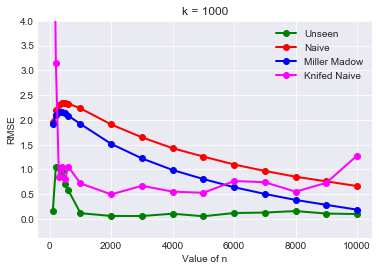

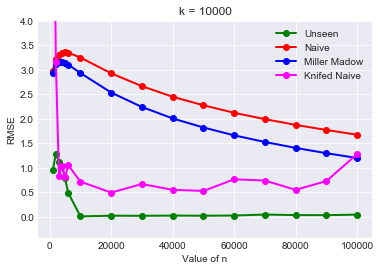

In [58]:
for k in plot_data.keys():
    n_list = plot_data[k]['n_list']
    rmse = plot_data[k]['rmse']
    n_rmse = plot_data[k]['n_rmse']
    mm_rmse = plot_data[k]['mm_rmse']
    plt.style.use('seaborn-darkgrid')
    plt.title("k = " + str(k))
    plt.plot( n_list, rmse, marker='o', color='green', linewidth=2, label='Unseen')
    plt.plot( n_list, n_rmse, marker='o', color='red', linewidth=2, label='Naive')
    plt.plot( n_list, mm_rmse, marker='o', color='blue', linewidth=2, label='Miller Madow')
    plt.plot( n_list, kn_rmse, marker='o', color='magenta', linewidth=2, label='Knifed Naive')
    plt.ylim(top=4) 
    plt.ylabel('RMSE')
    plt.xlabel('Value of n')
    plt.legend()
    plt.show()